# My Version of d2l_concise_rnn

In [28]:
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

通过运行load_data_time_machine函数，我们得到了train_iter（就是之前的corpus，即词元索引列表批量）和vocab（即时光机器语料库的词表（char为单元））。train_iter的形式可以参见language_dataset部分。

train_iter为长度10000的序列，batch_size=32, num_steps=35说明一对X和Y各有32个子序列，每个子序列长度为35

## 定义及初始化模型

我们首先定义一个256个隐藏单元的单隐藏层rnn_layer。

In [29]:
num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)
rnn_layer

RNN(28, 256)

接下来，我们使用张量来初始化隐状态，它的形状是（隐藏层数，批量大小，隐藏单元数）

In [30]:
state = torch.zeros((1, batch_size, num_hiddens))
state.shape

torch.Size([1, 32, 256])

In [31]:
X = torch.rand(size=(num_steps, batch_size,len(vocab)))
Y, state_new = rnn_layer(X, state)
# Y.shape, state_new.shape

print(Y.shape, state_new.shape)
linear = nn.Linear(num_hiddens, len(vocab))
Y = Y.reshape((-1, Y.shape[-1]))
print(Y.shape)
Y = linear(Y.reshape((-1, Y.shape[-1])))
print(Y.shape)

torch.Size([35, 32, 256]) torch.Size([1, 32, 256])
torch.Size([1120, 256])
torch.Size([1120, 28])


接下来，定义一个完整的模型RNNModel类。其中，rnn_layer只包含隐藏的循环层，还需要创建一个单独的输出层。

In [32]:
class RNNModel(nn.Module):
    def __init__(self,rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        self.num_directions = 1
        self.linear = nn.Linear(self.num_hiddens, self.vocab_size)

    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # 首先通过reshape将Y的形状改为(时间步数*批量大小,隐藏单元数)
        # 然后linear层将Y的形状变换为(时间步数*批量大小,词表大小)
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # nn.GRU以张量作为隐状态
            return  torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device)
        else:
            # nn.LSTM以元组作为隐状态
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.num_directions * self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))



## 训练和预测

In [33]:
def predict_ch8(prefix, num_preds, net, vocab, device):
    """Generate new characters following the `prefix`.

    Defined in :numref:`sec_rnn_scratch`"""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: d2l.reshape(d2l.tensor(
        [outputs[-1]], device=device), (1, 1))
    for y in prefix[1:]:  # Warm-up period
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # Predict `num_preds` steps
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [34]:
device = d2l.try_gpu()
my_rnn = RNNModel(rnn_layer, vocab_size=len(vocab))
my_rnn = my_rnn.to(device)
predict_ch8('time traveller', 10, my_rnn, vocab, device)

'time travellernununununu'

接下来是定义训练过程

首先是单个epoch的训练

In [35]:
def grad_clipping(net, theta):
    """Clip the gradient.

    Defined in :numref:`sec_rnn_scratch`"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [36]:
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """Train a net within one epoch (defined in Chapter 8).

    Defined in :numref:`sec_rnn_scratch`"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # Initialize `state` when either it is the first iteration or
            # using random sampling
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # `state` is a tensor for `nn.GRU`
                state.detach_()
            else:
                # `state` is a tuple of tensors for `nn.LSTM` and
                # for our custom scratch implementation
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # Since the `mean` function has been invoked
            updater(batch_size=1)
        metric.add(l * d2l.size(y), d2l.size(y))
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

然后是多个epoch的训练：

In [37]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """Train a model (defined in Chapter 8).

    Defined in :numref:`sec_rnn_scratch`"""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # Initialize
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # 此处只是定义了predict的模型
    # Train and predict
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'perplexity {ppl:.1f}, {speed:.1f} tokens/sec on {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

perplexity 1.3, 82725.9 tokens/sec on cpu
time traveller hal ghate te thas ix fime tor ofrer wayli go un i
traveller but now you begin toose has somy he hime drecthan


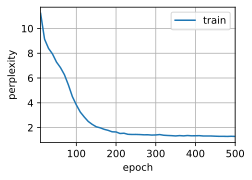

In [38]:
num_epochs, lr = 500, 1
train_ch8(my_rnn, train_iter, vocab, lr, num_epochs, device)